# Three paradigms for modeling: curve-fitting, probabilistic models and uncertainty quantification, illustrated using the MMI data

By Charles Zheng, using data from Keren et al. (2020)

## Importing the data

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
# Import the data
ts = pd.read_csv('../data/mturk.csv', index_col=0)

In [3]:
# Columns
ts.columns

Index(['CertainAmount', 'Outcome1', 'Outcome2', 'isHappyBlock', 'Happiness',
       'Outcome', 'time', 'subject_id', 'InterpHappiness', 'MoodTarget',
       'Expected', 'Actual', 'CertCol', 'ExpectedCol', 'RPECol', 'Gamble',
       'RutC', 'RutE', 'RutR', 'block'],
      dtype='object')

In [4]:
n_trials = 81
n_subjects = int(len(ts)/n_trials)
# reformat data into separate variables that are #trials x #subjects
all_trial_nos = ts.time.values.reshape((-1, n_trials)).T
all_participant = ts.subject_id.values.reshape((-1, n_trials)).T
all_outcome1 = ts.Outcome1.values.reshape((-1, n_trials)).T
all_outcome2 = ts.Outcome2.values.reshape((-1, n_trials)).T
all_certainAmount = ts.CertainAmount.values.reshape((-1, n_trials)).T
all_choice = ts.Gamble.values.reshape((-1, n_trials)).T
all_outcomeAmount = ts.Actual.values.reshape((-1, n_trials)).T
all_mood_rating = ts['Happiness'].values.reshape((-1, n_trials)).T
n_subjects

80

In [5]:
all_winAmount = np.maximum(all_outcome1, all_outcome2)
all_loseAmount = np.minimum(all_outcome1, all_outcome2)


## I. Curve-fitting

The LTA model with time drift is defined as follows

$E(t) = \frac{1}{t-1}\sum_{u=1}^{t-1} A(u)$

$\hat{M}(t) = M_0 + \beta_E \sum_{u=1}^t \lambda^{t-u} E(u) + \beta_A \sum_{u=1}^t \lambda^{t-u} A(u) + \beta_T T(t)$

where $A(t)$ is the actual outcome of trial $t$, $T(t)$ is the time stamp (here just the trial number), $M(t)$ is the mood rating.

$\lambda$ and $M_0$ are constrained to lie in [0,1].  $\beta_A$ and $\beta_E$ are constrained to be nonnegative.  There are no constraints on $\beta_T$.


In [6]:
## Define a class for the LTA model

class CurveLTA(object):
    
    def __init__(self):
        pass
    
    # intializes with some default parameters
    def initialize(self):
        self.m0 = 0.5
        self.lam = 0.8
        self.betaE = 0.01
        self.betaA = 0.005
        self.betaT = 0.0001
    
    def predict(self, actual, timestamps):
        n_trials = len(actual)
        # holds the predicted moods
        mood_pred = np.zeros(n_trials) 
        # Holds the exponentially weighted sums for E(t) and A(t)
        sum_E = 0
        sum_A = 0
        for trial_no in range(n_trials):
            if trial_no == 0:
                lte = 0
            else:
                lte = np.mean(actual[:trial_no])
            sum_E = sum_E * self.lam + lte
            sum_A = sum_A * self.lam + actual[trial_no]
            mood_mu = self.m0 + self.betaE * sum_E + self.betaA * sum_A + self.betaT * timestamps[trial_no]
            mood_pred[trial_no] = mood_mu
        return mood_pred
        

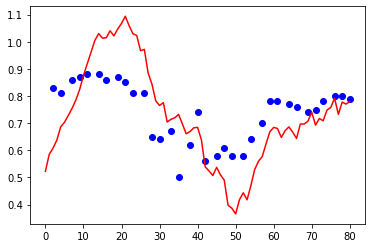

In [7]:
# use a single subject for all demonstrations
subject_index = 8
time = all_trial_nos[:, subject_index]
actual = all_outcomeAmount[:, subject_index]
mood = all_mood_rating[:, subject_index]
highGamble = all_winAmount[:, subject_index]
lowGamble = all_loseAmount[:, subject_index]
certain = all_certainAmount[:, subject_index]
choice = all_choice[:, subject_index]

CL = CurveLTA()
CL.initialize()
plt.plot(time, CL.predict(actual, time), c="r")
plt.scatter(time, mood, c="b")

### Defining a loss function for optimization

In [8]:
from scipy.optimize import minimize, Bounds

In [9]:
CL = CurveLTA()
def loss_func(par):
    CL.m0, CL.lam, CL.betaE, CL.betaA, CL.betaT = par
    mood_pred = CL.predict(actual, time)
    return np.nansum(np.abs(mood - mood_pred))
    

In [10]:
# What's the loss on the default parameters?
loss_func([0.5,0.8,0.01,0.005,0.0001])

3.764776581483656

In [11]:
# call to minimize the function
minimize(loss_func, [0.5,0.8,0.01,0.005,0.0001], 
         bounds=Bounds([0.0,0.0,0.0,0.0,-np.inf],[1.0, 1.0, np.inf,np.inf,np.inf]))

      fun: 0.95492225837828
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.80214225,  -1.06562211, 174.36130554,  14.45814094,
         5.24117336])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2910
      nit: 98
     njev: 485
   status: 0
  success: True
        x: array([ 0.7529024 ,  0.7624221 ,  0.        ,  0.00388044, -0.00105421])

In [12]:
# Now add the minimization to the class

class CurveLTA(object):
    
    _par_names = ['m0','lam','betaE','betaA','betaT']
    _default_pars = [0.5,0.8,0.01,0.005,0.0001]
    _lower_bounds = [0.0,0.0,0.0,0.0,-np.inf]
    _upper_bounds = [1.0, 1.0, np.inf,np.inf,np.inf]
    
    def __init__(self):
        pass
    
    # intializes with some default parameters
    def initialize(self):
        self.m0, self.lam, self.betaE, self.betaA, self.betaT = self._default_pars
    
    def fit(self, actual, timestamps, mood):
        def loss_func(par):
            self.m0, self.lam, self.betaE, self.betaA, self.betaT = par
            mood_pred = self.predict(actual, time)
            return np.nansum(np.abs(mood - mood_pred))
        res = minimize(loss_func, self._default_pars, 
            bounds=Bounds(self._lower_bounds,self._upper_bounds))
        self.m0, self.lam, self.betaE, self.betaA, self.betaT = res.x
        return res
    
    def predict(self, actual, timestamps):
        n_trials = len(actual)
        # holds the predicted moods
        mood_pred = np.zeros(n_trials) 
        # Holds the exponentially weighted sums for E(t) and A(t)
        sum_E = 0
        sum_A = 0
        for trial_no in range(n_trials):
            if trial_no == 0:
                lte = 0
            else:
                lte = np.mean(actual[:trial_no])
            sum_E = sum_E * self.lam + lte
            sum_A = sum_A * self.lam + actual[trial_no]
            mood_mu = self.m0 + self.betaE * sum_E + self.betaA * sum_A + self.betaT * timestamps[trial_no]
            mood_pred[trial_no] = mood_mu
        return mood_pred
        


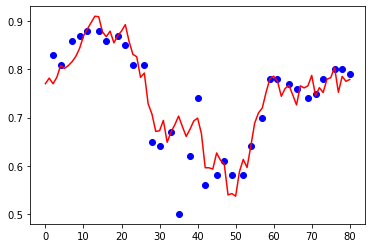

In [13]:
CL = CurveLTA()
CL.fit(actual, time, mood)
plt.plot(time, CL.predict(actual, time), c="r")
plt.scatter(time, mood, c="b")

In [14]:
# MAE
np.nanmean(np.abs(mood - CL.predict(actual, time)))

0.028085948775831766

### Regularized curve-fitting

Now we add L1 penalties to the coefficients

In [15]:
# Now add the minimization to the class

class CurveLTA(object):
    
    _par_names = ['m0','lam','betaE','betaA','betaT']
    _default_pars = [0.5,0.8,0.01,0.005,0.0001]
    _lower_bounds = [0.0,0.0,0.0,0.0,-np.inf]
    _upper_bounds = [1.0, 1.0, np.inf,np.inf,np.inf]
    pen_betaE = 0.0
    pen_betaA = 0.0
    pen_betaT = 0.0
    
    def __init__(self, pen_betaE = 0.0, pen_betaA = 0.0, pen_betaT = 0.0):
        self.pen_betaE = pen_betaE
        self.pen_betaA = pen_betaA
        self.pen_betaT = pen_betaT
    
    # intializes with some default parameters
    def initialize(self):
        self.m0, self.lam, self.betaE, self.betaA, self.betaT = self._default_pars
    
    def fit(self, actual, timestamps, mood):
        def loss_func(par):
            self.m0, self.lam, self.betaE, self.betaA, self.betaT = par
            mood_pred = self.predict(actual, time)
            pen_term = np.abs(self.pen_betaE * self.betaE) + \
                np.abs(self.pen_betaA * self.betaA) + \
                np.abs(self.pen_betaT * self.betaT)
            return np.nansum(np.abs(mood - mood_pred)) + pen_term
        res = minimize(loss_func, self._default_pars, 
            bounds=Bounds(self._lower_bounds,self._upper_bounds))
        self.m0, self.lam, self.betaE, self.betaA, self.betaT = res.x
        return res
    
    def predict(self, actual, timestamps):
        n_trials = len(actual)
        # holds the predicted moods
        mood_pred = np.zeros(n_trials) 
        # Holds the exponentially weighted sums for E(t) and A(t)
        sum_E = 0
        sum_A = 0
        for trial_no in range(n_trials):
            if trial_no == 0:
                lte = 0
            else:
                lte = np.mean(actual[:trial_no])
            sum_E = sum_E * self.lam + lte
            sum_A = sum_A * self.lam + actual[trial_no]
            mood_mu = self.m0 + self.betaE * sum_E + self.betaA * sum_A + self.betaT * timestamps[trial_no]
            mood_pred[trial_no] = mood_mu
        return mood_pred
        


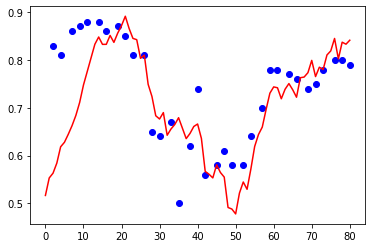

In [16]:
CL = CurveLTA(pen_betaE = 0.1, pen_betaA = 0.1)
CL.fit(actual, time, mood)
plt.plot(time, CL.predict(actual, time), c="r")
plt.scatter(time, mood, c="b")

In [17]:
# MAE
np.nanmean(np.abs(mood - CL.predict(actual, time)))

0.061679987888685284

### Held-out prediction

We fit to the first 40 trials and predict on the remaining

In [18]:
CL.fit(actual[:40], time[:40], mood[:40])

      fun: 1.2785826465804988
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.        ,   4.19286403,  40.12511421,  -0.22806657,
       -21.04029444])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 600
      nit: 7
     njev: 100
   status: 2
  success: False
        x: array([ 0.50003793,  0.79989383,  0.00931449,  0.00331585, -0.00393954])

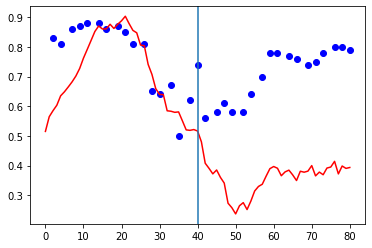

In [19]:
plt.plot(time, CL.predict(actual, time), c="r")
plt.axvline(40)
plt.scatter(time, mood, c="b")

In [20]:
# MAE (training, test)
errs = np.abs(mood - CL.predict(actual, time))
np.nanmean(errs[:40]), np.nanmean(errs[40:])

(0.07983247578286148, 0.3392732638871851)


## IIa. Likelihood model

Now we add a utility function and jointly model mood with decision-making.

**Data variables:**

 * $H(t)$ high gamble
 * $L(t)$ low gamble
 * $C(t)$ deterministic amount
 * $A(t)$ actual outcome
 * $G(t)$ whether gambling occurred
 * $T(t)$ time elapsed
 
Define $W(t) = 1$ if $A(t)=H(t)$ and $G(t) = 1$, and $W(t)=0$ otherwise.

Define the subjective win probability as

$p(t) = \frac{\sum_{i=1}^{t-1} W(i)}{\sum_{i=1}^{t-1} G(i)}$

with $p(t) = 0.5$ when it would otherwise be undefined.

**Model parameters:**

 * $M_0 \in (-\infty,\infty)$ baseline logit-mood
 * $\lambda \in [0,1]$ discount factor
 * $\beta_E \in [0,\infty)$ coefficient for LTA
 * $\beta_A \in [0,\infty)$ coefficient for actual outcome
 * $\beta_T \in (-\infty,\infty)$ coefficient for time trend
 * $\gamma \in [0,2]$ utility function exponent
 * $\rho_C \in [0,\infty)$ choice inverse temperature
 * $\sigma \in [0,\infty)$ Gaussian noise standard deviation for logit-mood

**Latent variables:**

 * *Choice bias*: $V(t) = \rho_C(p(t) H(t)^\gamma + (1-p(t)) L(t)^\gamma - C(t)^\gamma)$
 * *Long-term average*: $E(t) = \frac{1}{t-1}\sum_{u=1}^{t-1} A(u)^\gamma$
 * *Predicted logit-mood*: $\mu(t) = M_0 + \beta_E \sum_{u=1}^t \lambda^{t-u} E(u) + \beta_A \sum_{u=1}^t \lambda^{t-u} A(u)^\gamma + \beta_T T(t)$

**Model:**

 * $G(t) \sim \text{Binomial}(\text{expit}(V(t))$
 * $M(t) \sim \text{LogitNormal}(\mu(t),\sigma)$
 
where $\text{expit}(x) = \frac{1}{1 + e^{-x}}$

In [21]:
from scipy.stats import norm, bernoulli
from scipy.special import logit, expit

In [22]:
def signedPower(x, y):
    return np.power(np.abs(x), y) * np.sign(x)

class MoodChoiceLTA(object):
    
    _model_name = 'LTA nonlinear with simple win prob. and choice'
    _par_names = np.array(['m0','lam','betaE','betaA','betaT','gamma','rhoC','sigma'])
    _default_pars = np.array([0.0,0.8,0.01,0.005,0.0001,1.0,1.0,0.5])
    _lower_bounds = np.array([-np.inf,0.0,0.0,0.0,-np.inf,0.0,0.0,0.0])
    _upper_bounds = np.array([np.inf, 1.0, np.inf,np.inf,np.inf,2.0,np.inf,np.inf])
    
    def __init__(self):
        pass
    
    # prints parameters
    def __str__(self):
        s = self._model_name
        for par in self._par_names:
            s = s + '\n' + par + ': %.4f' % self.__dict__[par]
        return s
    
    # intializes with some default parameters
    def initialize(self, params = None):
        if params is None:
            params = self._default_pars
        self.m0, self.lam, self.betaE, self.betaA, self.betaT, \
            self.gamma, self.rhoC, self.sigma = params
    
    def fit(self, actual, certain, highGamble, lowGamble, choice, timestamps, mood):
        def loss_func(par):
            self.m0, self.lam, self.betaE, self.betaA, self.betaT, \
                self.gamma, self.rhoC, self.sigma = par
            return -self.loglike(actual, certain, highGamble, lowGamble, choice, timestamps, mood)
        res = minimize(loss_func, self._default_pars, 
            bounds=Bounds(self._lower_bounds,self._upper_bounds))
        self.m0, self.lam, self.betaE, self.betaA, self.betaT, \
            self.gamma, self.rhoC, self.sigma = res.x
        return res
    
    def loglike(self, actual, certain, highGamble, lowGamble, choice, timestamps, mood):
        # check bounds
        pars = np.array([self.m0, self.lam, self.betaE, self.betaA, self.betaT, \
                self.gamma, self.rhoC, self.sigma])
        if np.any(pars > self._upper_bounds):
            return -np.inf
        if np.any(pars < self._lower_bounds):
            return -np.inf
        mood_logit, choice_logit = self.predict(actual, certain, highGamble, lowGamble, choice, timestamps)
        if np.any(np.isnan(mood_logit)):
            return -np.inf
        if np.any(np.isnan(choice_logit)):
            return -np.inf
        choice_ll = bernoulli.logpmf(choice, expit(choice_logit))
        mood_ll = norm.logpdf(logit(mood), loc=mood_logit, scale=self.sigma)
        return np.nansum(choice_ll) + np.nansum(mood_ll)
    
    def predict(self, actual, certain, highGamble, lowGamble, choice, timestamps):
        n_trials = len(actual)
        # compute the win probabilities
        winIndicator = (highGamble == actual) * choice
        pwin = 0.5 * np.ones(n_trials)
        temp1 = np.cumsum(winIndicator, axis = 0)
        temp2 = np.cumsum(choice, axis = 0)
        pwin[temp2 > 0] = temp1[temp2 > 0]/temp2[temp2 > 0]
        pwin = np.concatenate(([0.5], pwin[:-1]))
        # holds the predicted moods and choices
        mood_logit = np.zeros(n_trials)
        choice_logit = np.zeros(n_trials)
        # Holds the exponentially weighted sums for E(t) and A(t)
        sum_E = 0
        sum_A = 0
        for trial_no in range(n_trials):
            if trial_no == 0:
                lte = 0
            else:
                lte = np.mean(signedPower(actual[:trial_no], self.gamma))
            sum_E = sum_E * self.lam + lte
            sum_A = sum_A * self.lam + signedPower(actual[trial_no], self.gamma)
            choice_bias = self.rhoC * \
                (pwin[trial_no] * signedPower(highGamble[trial_no], self.gamma) + \
                 (1-pwin[trial_no]) * signedPower(lowGamble[trial_no], self.gamma) - \
                 signedPower(certain[trial_no], self.gamma))
            mood_mu = self.m0 + self.betaE * sum_E + self.betaA * sum_A + self.betaT * timestamps[trial_no]
            mood_logit[trial_no] = mood_mu
            choice_logit[trial_no] = choice_bias
        return mood_logit, choice_logit
    
    def sample(self, actual, certain, highGamble, lowGamble, choice, timestamps):
        mood_logit, choice_logit = self.predict(actual, certain, highGamble, lowGamble, choice, timestamps)
        mood_sample = expit(norm.rvs(loc=mood_logit, scale=self.sigma))
        choice_sample = bernoulli.rvs(expit(choice_logit))
        return mood_sample, choice_sample

In [23]:
# use a single subject for all demonstrations
subject_index = 8
time = all_trial_nos[:, subject_index]
actual = all_outcomeAmount[:, subject_index]
mood = all_mood_rating[:, subject_index]
highGamble = all_winAmount[:, subject_index]
lowGamble = all_loseAmount[:, subject_index]
certain = all_certainAmount[:, subject_index]
choice = all_choice[:, subject_index]


MCL = MoodChoiceLTA()
MCL.initialize()
#MCL.predict(actual, certain, highGamble, lowGamble, choice, time)
MCL.loglike(actual, certain, highGamble, lowGamble, choice, time, mood)

-147.53948026253795

In [24]:
MCL.fit(actual, certain, highGamble, lowGamble, choice, time, mood)

      fun: 21.035741990375005
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.19715794e-02, -2.11123562e-02,  5.07686114e+03, -1.05638307e+00,
       -1.76363812e-01, -1.65560011e-02, -7.40776330e-03, -9.21360766e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1746
      nit: 167
     njev: 194
   status: 0
  success: True
        x: array([ 1.29257785e+00,  7.48855194e-01,  0.00000000e+00,  1.84218201e-03,
       -7.10708878e-03,  1.99153976e+00,  2.79097889e-01,  2.41786990e-01])

In [25]:
MCL.loglike(actual, certain, highGamble, lowGamble, choice, time, mood)

-21.035741990375005

In [26]:
print(MCL)

LTA nonlinear with simple win prob. and choice
m0: 1.2926
lam: 0.7489
betaE: 0.0000
betaA: 0.0018
betaT: -0.0071
gamma: 1.9915
rhoC: 0.2791
sigma: 0.2418


## Parameter recovery example

In [27]:
# Simulate data
mood_s, choice_s = MCL.sample(actual, certain, highGamble, lowGamble, choice, time)
# copy missing pattern of original
mood_s[np.isnan(mood)] = np.nan

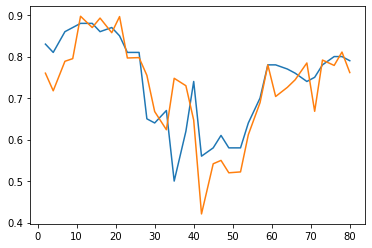

In [28]:
# plot original vs simulated mood
plt.plot(time[~np.isnan(mood)], mood[~np.isnan(mood)])
plt.plot(time[~np.isnan(mood)], mood_s[~np.isnan(mood)])

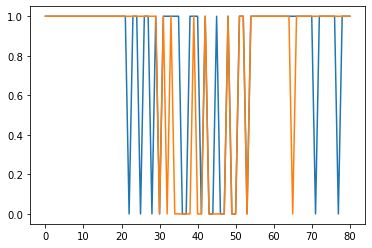

In [29]:
# plot choice
plt.plot(time, choice)
plt.plot(time, choice_s)

In [30]:
# fit on simulated
MCL2 = MoodChoiceLTA()
MCL2.fit(actual, certain, highGamble, lowGamble, choice_s, time, mood_s)

      fun: 12.731614005793201
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.02167186e-04, -3.96660480e-04, -3.51541019e-04,  3.11851878e-02,
        1.09473319e-02, -5.65947292e-04, -2.02504679e-05, -2.63611355e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1377
      nit: 124
     njev: 153
   status: 0
  success: True
        x: array([ 0.88312737,  0.70698981,  0.00356373,  0.00567394, -0.00371719,
        1.62620607,  0.80106663,  0.2028806 ])

In [31]:
# simulated
print(MCL2)

LTA nonlinear with simple win prob. and choice
m0: 0.8831
lam: 0.7070
betaE: 0.0036
betaA: 0.0057
betaT: -0.0037
gamma: 1.6262
rhoC: 0.8011
sigma: 0.2029


In [32]:
# original
MCL0=MCL
print(MCL)

LTA nonlinear with simple win prob. and choice
m0: 1.2926
lam: 0.7489
betaE: 0.0000
betaA: 0.0018
betaT: -0.0071
gamma: 1.9915
rhoC: 0.2791
sigma: 0.2418


## IIb: Bayesian model

We now add prior distributions to the previous model parameters

In [33]:
! mkdir ../code
! cd ../code ; git clone https://github.com/compmem/RunDEMC
%pip install -e ../code/RunDEMC

mkdir: ../code: File exists
fatal: destination path 'RunDEMC' already exists and is not an empty directory.
Obtaining file:///Users/nielsond/code/zheng_tutorial/code/RunDEMC
  Attempting uninstall: RunDEMC
    Found existing installation: RunDEMC 0.1.0
    Uninstalling RunDEMC-0.1.0:
      Successfully uninstalled RunDEMC-0.1.0
  Running setup.py develop for RunDEMC
Note: you may need to restart the kernel to use updated packages.


In [2]:
try:
    from RunDEMC import Model, Param, dists, calc_bpic, joint_plot
except ModuleNotFoundError:
    ! mkdir ../code
    ! cd ../code ; git clone https://github.com/compmem/RunDEMC
    %pip install -e ../code/RunDEMC

mkdir: ../code: File exists
fatal: destination path 'RunDEMC' already exists and is not an empty directory.
Obtaining file:///Users/nielsond/code/zheng_tutorial/code/RunDEMC
  Running setup.py develop for RunDEMC
Note: you may need to restart the kernel to use updated packages.


In [35]:
# Priors for parameters
params = [Param(name='m0',
                display_name=r'm0',
                prior=dists.normal(0, 1)),
          Param(name='lam',
                display_name=r'$lambda',
                prior=dists.normal(0, 1.4),
                transform=dists.invlogit
                ),
          Param(name='betaE',
                display_name=r'beta_E',
                prior=dists.normal(-3, 0.7),
                transform=np.exp,
                inv_transform=np.log),
          Param(name='betaA',
                display_name=r'beta_A',
                prior=dists.normal(-3, 0.7),
                transform=np.exp,
                inv_transform=np.log),
          Param(name='betaT',
                display_name=r'beta_T',
                prior=dists.normal(0, 0.01)),          
          Param(name='gamma',
                display_name=r'$\gamma$',
                prior=dists.gamma(1.5, 0.5),
                ),
          Param(name='rhoC',
                display_name=r'$rho_C$',
                prior=dists.gamma(1.5, 0.5),
                ),
          Param(name='sigma',
                display_name=r'sigma',
                prior=dists.exp(1))
        ]


In [36]:
# use a single subject for all demonstrations
subject_index = 8
time = all_trial_nos[:, subject_index]
actual = all_outcomeAmount[:, subject_index]
mood = all_mood_rating[:, subject_index]
highGamble = all_winAmount[:, subject_index]
lowGamble = all_loseAmount[:, subject_index]
certain = all_certainAmount[:, subject_index]
choice = all_choice[:, subject_index]

In [37]:
def eval_fun(params):
    md = MoodChoiceLTA()
    params2 = np.array([params[n] for n in md._par_names])
    n_params, n_particles = params2.shape
    ll = -np.inf * np.ones(n_particles)
    for ind_part in range(n_particles):
        md.initialize(params2[:, ind_part])
        ll[ind_part] = md.loglike(actual, certain, highGamble, lowGamble, choice, time, mood)
    return ll

In [38]:
MCL._par_names

array(['m0', 'lam', 'betaE', 'betaA', 'betaT', 'gamma', 'rhoC', 'sigma'],
      dtype='<U5')

In [39]:
m = Model('mmi', params=params,
    like_fun=eval_fun,
    init_multiplier = 3,
    use_priors = True,
    verbose=True)

In [40]:
m._initialize(num_chains=50)

Initializing: 150(50) 

In [41]:
np.min(m.weights[-1]), np.max(m.weights[-1])

(-591023.9104212637, -104.18834819904447)

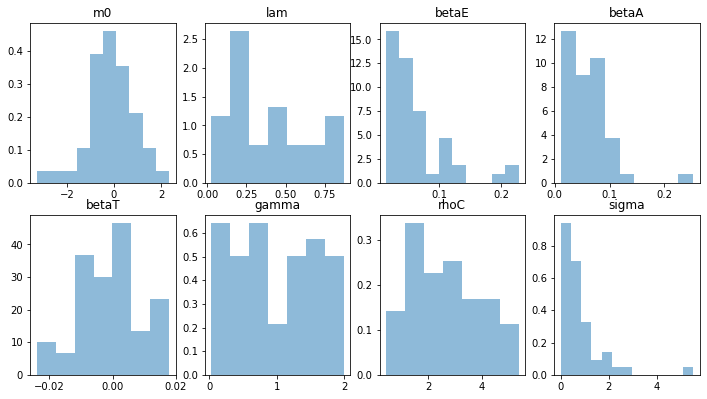

In [42]:
plt.figure(figsize=(12,10))
for i in range(8):
    plt.subplot(3,4,i+1)
    plt.hist(m.particles[:, :, i].flatten(), bins='auto', alpha=.5, density=True)
    plt.title(MCL._par_names[i])

In [43]:
times = m.sample(100, burnin=True, migration_prob = 0.1)

Iterations (100): x 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 x 30 31 32 x 33 34 35 36 37 38 39 40 x 41 x 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 x 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 x 80 81 x 82 83 84 85 86 x 87 88 89 x 90 91 x 92 93 x 94 95 x 96 97 x 98 99 100 


In [44]:
np.min(m.weights[-1]), np.max(m.weights[-1])

(-53.01794483360497, -46.369464228453765)

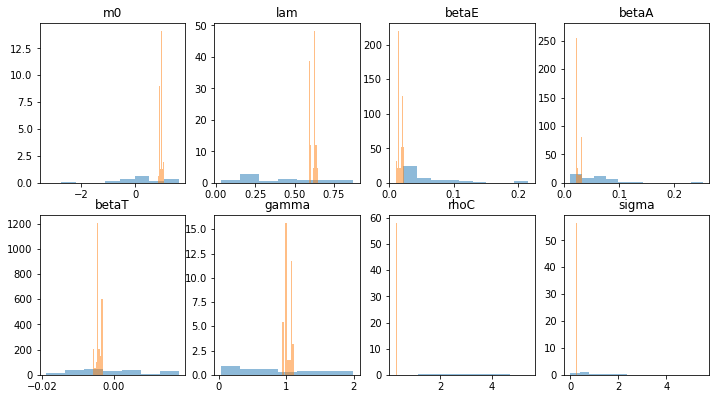

In [45]:
plt.figure(figsize=(12,10))
for i in range(8):
    plt.subplot(3,4,i+1)
    plt.hist(m.particles[0, :, i].flatten(), bins='auto', alpha=.5, density=True)
    plt.hist(m.particles[-1, :, i].flatten(), bins='auto', alpha=.5, density=True)
    plt.title(MCL._par_names[i])

In [46]:
times = m.sample(100, burnin=False)

Iterations (100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 


0

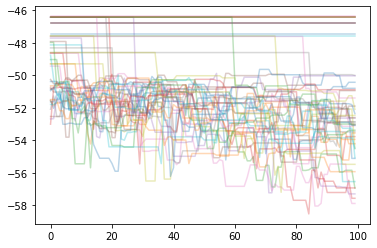

In [47]:
# show the chains are mixing and converging
plt.plot(m.weights[-100:], alpha=.3)
0

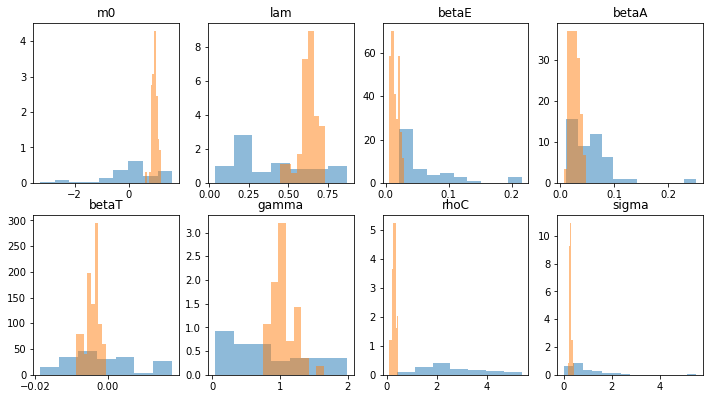

In [48]:
plt.figure(figsize=(12,10))
for i in range(8):
    plt.subplot(3,4,i+1)
    plt.hist(m.particles[0, :, i].flatten(), bins='auto', alpha=.5, density=True)
    plt.hist(m.particles[-1, :, i].flatten(), bins='auto', alpha=.5, density=True)
    plt.title(MCL._par_names[i])

In [49]:
df = pd.DataFrame(m.particles[-1,:,:])
df.columns = MCL._par_names
df['loglike'] = m.weights[-1]
df.head()

,m0,lam,betaE,betaA,betaT,gamma,rhoC,sigma,loglike
0,1.024669,0.632544,0.009243,0.032883,-0.002800,0.933682,0.212200,0.288910,-55.124673
1,0.861508,0.638160,0.021325,0.040396,-0.002262,0.885636,0.428256,0.324870,-54.220637
2,0.885945,0.595888,0.019561,0.022786,-0.003130,1.083021,0.279915,0.240902,-46.811001
3,1.167979,0.624594,0.008704,0.016534,-0.008186,1.250732,0.221427,0.333174,-53.783473
4,0.942858,0.626464,0.024310,0.043054,-0.005647,0.827182,0.450080,0.261487,-52.647115


In [50]:
def ll(params):
    MCL = MoodChoiceLTA()
    MCL.initialize(params)
    return MCL.loglike(actual, certain, highGamble, lowGamble, choice, time, mood)

In [51]:
np.array([ll(p) for p in m.particles[-1, :, :]])

array([-48.29446448, -50.04660211, -46.23875735, -45.19522901,
       -48.58432054, -43.34490806, -44.9165465 , -45.5936273 ,
       -50.26119221, -46.05082967, -46.54175844, -49.47804173,
       -49.34859663, -52.82118873, -53.31515652, -46.24653102,
       -43.97277519, -48.76024704, -44.98782045, -46.23875735,
       -44.65684104, -44.38307123, -44.98782045, -50.98342427,
       -44.98782045, -47.88824963, -46.54175844, -43.56881339,
       -44.94285673, -46.1978183 , -47.66765755, -44.60055413,
       -45.66897255, -46.23875735, -43.16839333, -46.67221633,
       -52.11479199, -46.23875735, -51.46221274, -46.17257505,
       -44.31471693, -44.98782045, -46.65603679, -44.00317446,
       -46.23875735, -44.98782045, -45.13743131, -45.68778688,
       -47.45058975, -50.64501515])

In [52]:
def plot_preds(params):
    MCL = MoodChoiceLTA()
    MCL.initialize(params)
    m1, c1 = MCL.predict(actual, certain, highGamble, lowGamble, choice, time)
    plt.plot(expit(m1))
    plt.plot(expit(c1))
    plt.ylim([-0.1,1.1])
    plt.scatter(time, mood)
    plt.scatter(time, choice)
    

In [53]:
params = m.particles[-1, 3, :]
MCL = MoodChoiceLTA()
MCL.initialize(params)
m1, c1 = MCL.predict(actual, certain, highGamble, lowGamble, choice, time)

In [54]:
MCL.loglike(actual, certain, highGamble, lowGamble, choice, time, mood)

-45.195229007288454

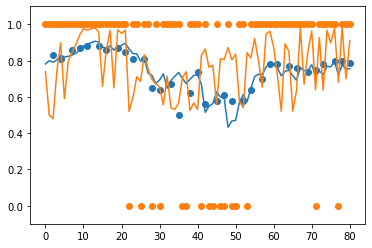

In [55]:
plot_preds(m.particles[-1, 3, :]) # blue is mood, orange is gambling prob

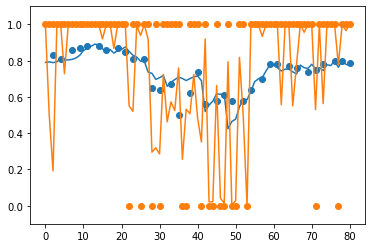

In [56]:
# plot MLE
m1, c1 = MCL0.predict(actual, certain, highGamble, lowGamble, choice, time)
plt.plot(expit(m1))
plt.plot(expit(c1))
plt.ylim([-0.1,1.1])
plt.scatter(time, mood)
plt.scatter(time, choice)